In [0]:
import numpy as np
from keras.utils import np_utils
import keras.layers as KL
import keras.backend as K
import keras.models as KM													  
from keras.layers import Activation,Conv2D,MaxPooling2D,BatchNormalization,Input,DepthwiseConv2D,add,Dropout,AveragePooling2D,Concatenate
from keras.engine import Layer,InputSpec
from keras.utils import conv_utils
import tensorflow as tf
from keras.preprocessing.image import img_to_array,load_img
import matplotlib.pyplot as plt


In [0]:

from glob import glob
# !unzip /content/idd20k_lite.zip
#unzips the file content

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
cp -r '/content/drive/My Drive/idd20k_lite' /content/

In [0]:
#retrieving the list of files matching the specified pattern
#retrieving train image path
ff=glob('/content/idd20k_lite/leftImg8bit/train/*/*_image.jpg')
#train label path
ee = [p.replace('leftImg8bit', 'gtFine').replace(
            '_image.jpg', '_label.png') for p in ff]
#test image path
ffr=glob('/content/idd20k_lite/leftImg8bit/test/120/*_image.jpg')

In [0]:
#coverting images into arrays 
im=np.zeros((500,224,224,3),dtype=np.int)
la=np.zeros((500,224,224,3),dtype=np.int)
te=np.zeros((9,224,224,3),dtype=np.int)
for i in range(100):
  im[i]=img_to_array(load_img(ff[i],target_size=(224,224,3)))
  la[i]=img_to_array(load_img(ee[i],target_size=(224,224,3)))
  la[i][la[i] == 255] = 7
for i in range(9):
  te[i]=img_to_array(load_img(ffr[i],target_size=(224,224,3)))


In [0]:
#normalize the pixel values by dividing it by the max element in the array
ims=im/255
las=la

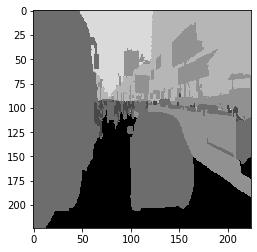

In [0]:
plt.imshow(las[90]/7)
# te.shape

RESNET as backbone CNN

In [0]:
#Identity block 
def identity_block(input_tensor, kernel_size, filters,train_bn=True):
   nb_filter1, nb_filter2, nb_filter3 = filters
   x = KL.Conv2D(nb_filter1, (1, 1),use_bias=True)(input_tensor)
   x = KL.BatchNormalization()(x,training=True)
   x = KL.Activation('relu')(x)

   x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',use_bias=True)(x)
   x = KL.BatchNormalization()(x,training=True)
   x = KL.Activation('relu')(x)

   x = KL.Conv2D(nb_filter3, (1, 1),use_bias=True)(x)
   x = KL.BatchNormalization()(x,training=True)

   x = KL.Add()([x, input_tensor])
   x = KL.Activation('relu')(x)
   return x
#Convolution block passing 
def conv_block(input_tensor, kernel_size, filters,strides=(2, 2), use_bias=True, train_bn=True):
    nb_filter1, nb_filter2, nb_filter3 = filters
    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides, use_bias=use_bias)(input_tensor)
    x = KL.BatchNormalization()(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same', use_bias=use_bias)(x)
    x = KL.BatchNormalization()(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), use_bias=use_bias)(x)
    x = KL.BatchNormalization()(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides, use_bias=use_bias)(input_tensor)
    shortcut = KL.BatchNormalization()(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu')(x)
    return x
#Resnet model - here first layer will be conv batch norm activation and maxpooling and followed by conv_block with identity block increased by one in each layer
def resnet_graph(input_image, train_bn=True):
    # Stage 1
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = KL.BatchNormalization()(x, training=train_bn)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    # Stage 2
    x = conv_block(x, 3, [64, 64, 256],strides=(1, 1), train_bn=train_bn)
    x = identity_block(x, 3, [64, 64, 256],train_bn=train_bn)
    C2 = x = identity_block(x, 3, [64, 64, 256], train_bn=train_bn)
    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], train_bn=train_bn)
    C3 = x = identity_block(x, 3, [128, 128, 512], train_bn=train_bn)
    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], train_bn=train_bn)
    for i in range(5):
        x = identity_block(x, 3, [256, 256, 1024], train_bn=train_bn)
    C4 = x
    return C4,C1
   #return output of forth layer and the lowlevel feature which is from first layer for aspp


In [0]:
#Bilinear upsampling used to scale features to correct dimension
class BilinearUpsampling(Layer):

    def __init__(self, upsampling=(2, 2), data_format=None, **kwargs):

        super(BilinearUpsampling, self).__init__(**kwargs)
        self.data_format =K.image_data_format()
        self.upsampling = conv_utils.normalize_tuple(upsampling, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        height = self.upsampling[0] * \
            input_shape[1] if input_shape[1] is not None else None
        width = self.upsampling[1] * \
            input_shape[2] if input_shape[2] is not None else None
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        return tf.image.resize_bilinear(inputs, (int(inputs.shape[1]*self.upsampling[0]),
                                                   int(inputs.shape[2]*self.upsampling[1])))

    def get_config(self):
        config = {'size': self.upsampling,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Atrous Spatial Pyramid Pooling

In [0]:
#Atrous spatial pyramid pooling uses 4 parallel operations
def aspp(x,input_shape,out_stride):
  #1*1 conv
  b0=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
  b0=BatchNormalization()(b0)
  #3*3 conv with Dilation rate = 6
  b0=Activation("relu")(b0)
  b1=DepthwiseConv2D((3,3),dilation_rate=(6,6),padding="same",use_bias=False)(x)
  b1=BatchNormalization()(b1)
  b1=Activation("relu")(b1)
  b1=Conv2D(256,(1,1),padding="same",use_bias=False)(b1)
  b1=BatchNormalization()(b1)
  b1=Activation("relu")(b1)
  #3*3 conv with Dilation rate = 12
  b2=DepthwiseConv2D((3,3),dilation_rate=(12,12),padding="same",use_bias=False)(x)
  b2=BatchNormalization()(b2)
  b2=Activation("relu")(b2)
  b2=Conv2D(256,(1,1),padding="same",use_bias=False)(b2)
  b2=BatchNormalization()(b2)
  b2=Activation("relu")(b2)	
  #3*3 conv with Dilation rate = 18
  b3=DepthwiseConv2D((3,3),dilation_rate=(18,18),padding="same",use_bias=False)(x)
  b3=BatchNormalization()(b3)
  b3=Activation("relu")(b3)
  b3=Conv2D(256,(1,1),padding="same",use_bias=False)(b3)
  b3=BatchNormalization()(b3)
  b3=Activation("relu")(b3)

  #image level features with average pooling
  out_shape=int(input_shape[0]/out_stride)
  b4=AveragePooling2D(pool_size=(out_shape,out_shape))(x)
  b4=Conv2D(256,(1,1),padding="same",use_bias=False)(b4)
  b4=BatchNormalization()(b4)
  b4=Activation("relu")(b4)
  b4=BilinearUpsampling((out_shape,out_shape))(b4)


  x=Concatenate()([b4,b0,b1,b2,b3])
  return x


#aspp
input_image = KL.Input(shape=[224,224,3], name="input_image")
x,C1=resnet_graph(input_image)
x=aspp(x,[224,224,3],16)
C1=Conv2D(256,(1,1),padding="same",use_bias=False)(C1)
C1=BatchNormalization()(C1)
C1=Activation("relu")(C1)
x=Dropout(0.9)(x)


##decoder 
#1*1 conv is applied on low level features to reduce no of channels
x=BilinearUpsampling((4,4))(x)
dec_skip=Conv2D(48,(1,1),padding="same",use_bias=False)(C1)
dec_skip=BatchNormalization()(dec_skip)
dec_skip=Activation("relu")(dec_skip)
x=Concatenate()([x,dec_skip])

#after two 3*3 cov layers, features are upsampled by 4
x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
x=BatchNormalization()(x)
x=Activation("relu")(x)
x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
x=BatchNormalization()(x)
x=Activation("relu")(x)

x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
x=BatchNormalization()(x)
x=Activation("relu")(x)
x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
x=BatchNormalization()(x)
x=Activation("relu")(x)

#features upsampled by 4
x=Conv2D(3,(1,1),padding="same")(x)
x=BilinearUpsampling((4,4))(x)





In [0]:
models=KM.Model(input_image,x)

In [0]:
models.summary()


In [0]:
                                  
# models.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['acc'])
                                  
models.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [0]:
models.fit(ims,las,epochs=15)

In [0]:
#predict image
m=models.predict(im)

In [0]:
# segmented image
ms=m[12]
# print(type(ms[1][1][1]))
#original image used for training 
imws=im[12]

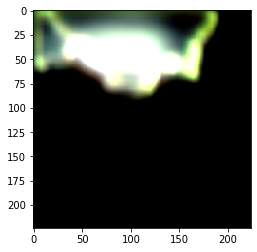

In [0]:
#plot segmented image
plt.imshow(ms/7)

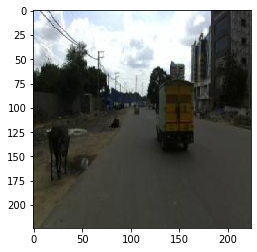

In [0]:
#plot original trained image 
plt.imshow(imws)